# Custom Data Example

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import scipy as sc

In [2]:
# this cell is generating some synthetic graph dataset with node features. 


#defining limits on number of nodes
n_min = 20
n_max = 50

#number of graphs
num_g = 100

# number of node features - in this example I will generate random node features that aren't useful for classifcation
n_nf = 3


# empty list of graphs and labels
graphs = []
labels = []
node_features = []


# setting limits on probability of edge existing for random graphs
p_min = 0.1
p_max = 0.5

# adding 50 random graphs (label 0)
for i in range(int(num_g/2)):
    rand_n = np.random.randint(n_min,n_max)
    rand_p = np.random.randint(int(p_min*100),int(p_max*100))/100   
    
    g = nx.fast_gnp_random_graph(rand_n,rand_p)    
    node_feat_matrix = np.random.random((rand_n,n_nf))
    
    graphs.append(nx.to_numpy_array(g))
    node_features.append(node_feat_matrix)
    
    labels.append(0)

# setting limits on number of edges to add per node
m_min = 1
m_max = 5

# adding 50  powerlaw cluster graphs (label 1)
for i in range(int(num_g/2)):
    rand_n = np.random.randint(n_min,n_max)
    rand_p = np.random.randint(int(p_min*100),int(p_max*100))/100   
    rand_m = np.random.randint(m_min,m_max)
    
    g = nx.powerlaw_cluster_graph(rand_n, rand_m, rand_p)
    node_feat_matrix = np.random.random((rand_n,n_nf))
    
    graphs.append(nx.to_numpy_array(g))
    node_features.append(node_feat_matrix)

    labels.append(1)

We now have three lists of length 100. The graphs list is composed of numpy arrays that represent the adjacency matrix of the graph. The node features list is composed of numpy arrays that contain the node information for each graph. The labels list is a list of integers that corresponds to the class label for each graph.

The next step is to take this data and convert it into an appropriate format for hcga.

In [3]:
# converting this data into the format required for hcga

from hcga.graph import Graph, GraphCollection

# create graph collection object
g_c = GraphCollection()


# looping over each graph and appending it to the graph collection object
for i,A in enumerate(graphs):
    
    # generating a sparse matrix
    sA = sc.sparse.coo_matrix(A)
    
    # extracting edge list from scipy sparse matrix
    edges = np.array([sA.row,sA.col,sA.data]).T
    
    # passing edge list to pandas dataframe
    edges_df = pd.DataFrame(edges, columns = ['start_node', 'end_node', 'weight'])

    # creating node ids based on size of adjancency matrix
    nodes = np.arange(0,A.shape[0])
    
    # loading node ids into dataframe
    nodes_df = pd.DataFrame(index=nodes)

    # each node should have the same number of node features across all graphs
    # converting node features array to list such that each node is assigned a list.
    nodes_df['attributes'] = node_features[i].tolist()

    # extracting graph label from labels
    graph_label = labels[i]
    
    # create a single graph object
    graph = Graph(nodes_df, edges_df, graph_label)

    # add new graph to the collection
    g_c.add_graph(graph)


In [4]:
# perform some sanity checks

print('There are {} graphs'.format(len(g_c.graphs)))
print('There are {} features per node'.format(g_c.get_n_node_features()))


There are 100 graphs
There are 3 features per node


In [5]:
# we can save this if we want to and run everything from the command line
from hcga.io import save_dataset

save_dataset(g_c, 'custom_dataset', folder='./datasets')

# Extracting features

We have now produced a pickle dataset of your own custom data. We can now run the feature extraction from the command line using the following commands:

hcga extract_features ./datasets/custom_dataset.pkl -m fast -n 4 -sl advanced --timeout 10 


Alternatively,we could import the Hcga class and run the feature extraction and analysis from within the notebook. We will do this below.

In [1]:
from hcga.io import load_dataset

graphs = load_dataset('./datasets/custom_dataset.pkl')

In [2]:
#import hcga object
from hcga.hcga import Hcga

# define an object
h = Hcga()

#assigning the graphs field to the recently created dataset
h.graphs = graphs

In [3]:
# extracting all features here
h.extract(mode='fast')

# saving all features into a pickle
h.save_features('./results/custom_dataset_results.pkl')


Returning the maximal subgraph for each graph


invalid value encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in log
invalid value encountered in double_scalars
invalid value encountered in true_divide
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
An input array is constant; the correlation coefficent is not defined.
divide by zero encountered in log
invalid value encountered in double_scalars
invalid value encountered in true_divide


Extracting features from 100 graphs (we disabled 0 graphs).
Computing features for 100 graphs:


  0%|          | 0/100 [00:00<?, ?it/s]Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
  1%|          | 1/100 [00:00<01:36,  1.03it/s]Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
DEBUG:Feature exceptions:Failed feature minimum_cycle_length for graph 2 with exception: zero-size array to reduction operation minimum which has no identity
  2%|▏         | 2/100 [00:02<01:37,  1.00it/s]divide by zero encountered in log
invalid value encountered in double_scalars
invalid value encountered in true_divide
invalid value encountered in double_scalars
Degrees of freedom <= 0 for slice
invalid value encountered in double_scalars
Degrees of freedom <= 0 for slice
k >= N - 1 for N * N square matrix. Attempting to use scipy.l

DEBUG:Feature exceptions:Failed feature degree_assortativity_coeff for graph 14 with exception: max() arg is an empty sequence
DEBUG:Feature exceptions:Failed feature degree_assortativity_coeff_pearson for graph 14 with exception: not enough values to unpack (expected 2, got 0)
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
 15%|█▌        | 15/100 [00:13<01:03,  1.34it/s]Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
 16%|█▌        | 16/100 [00:13<01:02,  1.35it/s]Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
 17%|█▋        | 17/100 [00:14<01:05,  1.27it/s]Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
 18%|█▊        | 18/100 [00:15<01:10,  1.16it/s]Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in log
divide by z

 32%|███▏      | 32/100 [00:31<01:07,  1.01it/s]Mean of empty slice.
invalid value encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
 33%|███▎      | 33/100 [00:33<01:28,  1.33s/it]divide by zero encountered in log
Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in log
divide by zero encountered in double_scalars
 34%|███▍      | 34/100 [00:35<01:22,  1.26s/it]Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
 35%|███▌      | 35/100 [00:35<01:12,  1.11s/it]Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
 36%|███▌      | 36/100 [00:37<01:22,  1.29s/it]Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
 37%|███▋      | 37/100 [00:38<01:13,  1.17s/it]Mean o

 71%|███████   | 71/100 [01:08<00:32,  1.11s/it]divide by zero encountered in log
Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in log
 72%|███████▏  | 72/100 [01:09<00:29,  1.07s/it]Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in log
 73%|███████▎  | 73/100 [01:10<00:28,  1.07s/it]Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
 74%|███████▍  | 74/100 [01:11<00:30,  1.18s/it]DEBUG:Feature exceptions:Failed feature minimum_cycle_length for graph 74 with exception: zero-size array to reduction operation minimum which has no identity
divide by zero encountered in log
Mean of empty slice.
invalid value encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in 

628 feature extracted.
371 valid features.


# Analysis - classification example

In [ ]:
# load the saved features

h.load_features('./results/custom_dataset/all_features.pkl')

INFO:hcga.analysis:1882 total features
INFO:hcga.utils:0 graphs were removed for more than 0.3 fraction of bad features
INFO:hcga.analysis:1768 valid features
INFO:hcga.analysis:1768 with interpretability 1
INFO:hcga.analysis:... Using Xgboost classifier ...
INFO:hcga.analysis:Using kfold
INFO:hcga.analysis:Using 10 splits
INFO:hcga.analysis:Fold accuracy: --- 1.0 ---
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
INFO:hcga.analysis:Fold accuracy: --- 1.0 ---
INFO:hcga.analysis:Fold accuracy: --- 1.0 ---
INFO:hcga.analysis:Fold accuracy: --- 1.0 ---
INFO:hcga.analysis:Fold accuracy: --- 1.0 ---
INFO:hcga.analysis:Fold accuracy: --- 1.0 ---
INFO:hcga.analysis:Fold accuracy: --- 0.9 ---
INFO:hcga.analysis:Fold accuracy: --- 1.0 ---
INFO:hcga.analysis:Fold accuracy: --- 1.0 ---
INFO:hcga.analysis:Fold accuracy: --- 1.0 ---
INFO:hcga.analysis:Accuracy: 0.99 +/- 0.03
INFO:hcga.analysis:Now using a reduced set of 101 features with < 0.9 correlation

Sample Expanded Feature Summary for Class 0


TypeError: 'int' object is not subscriptable

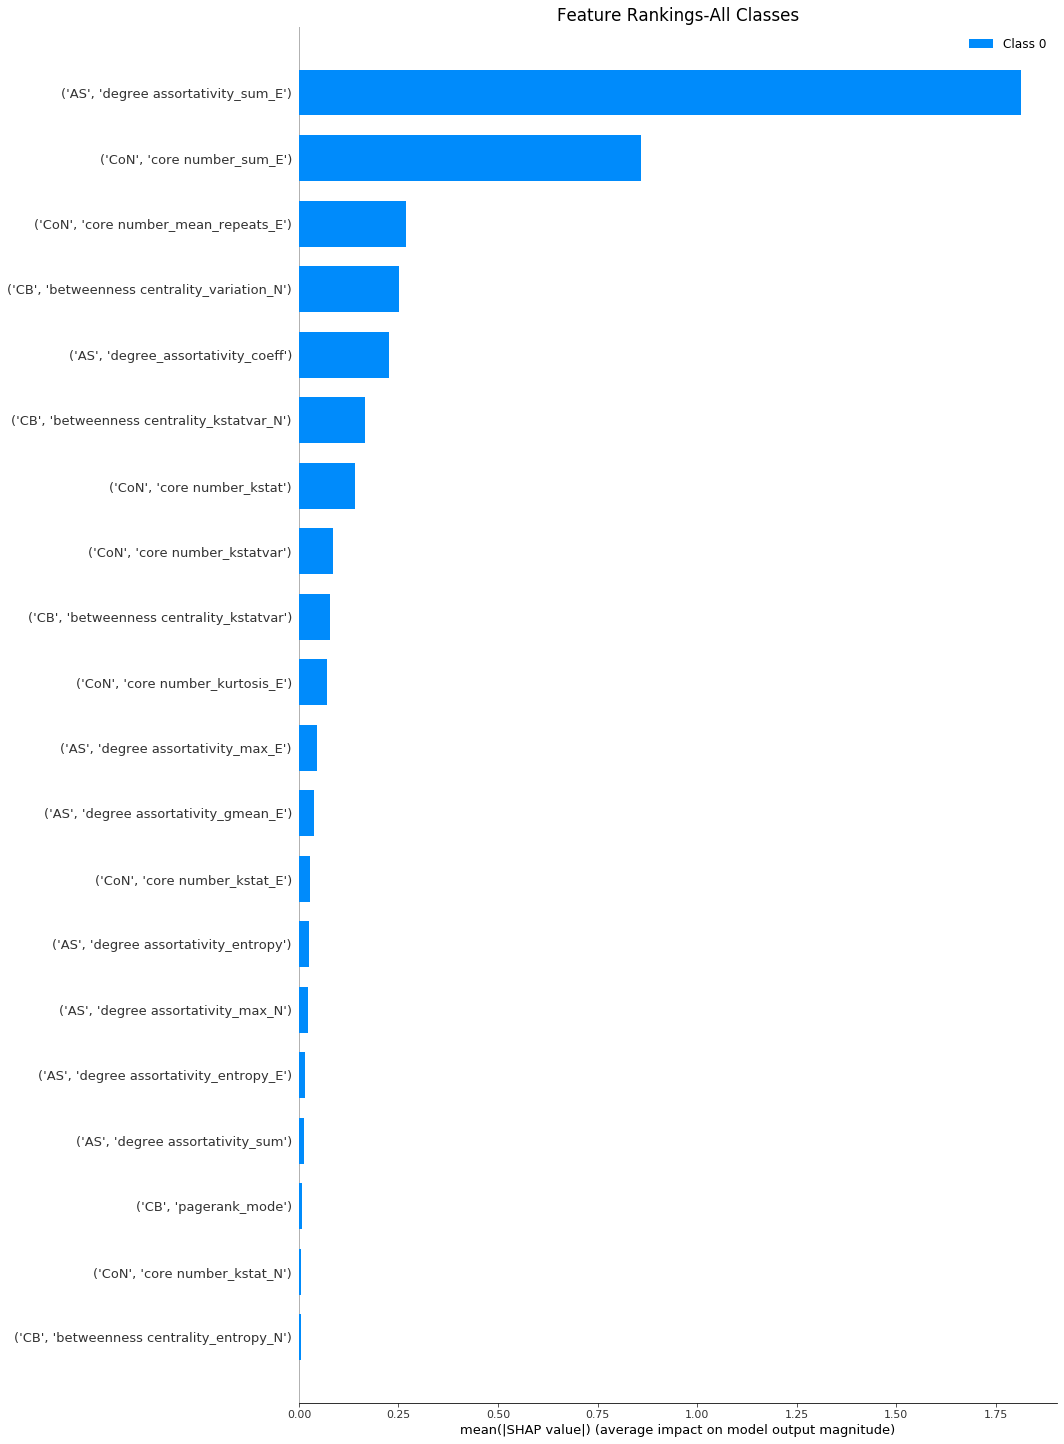

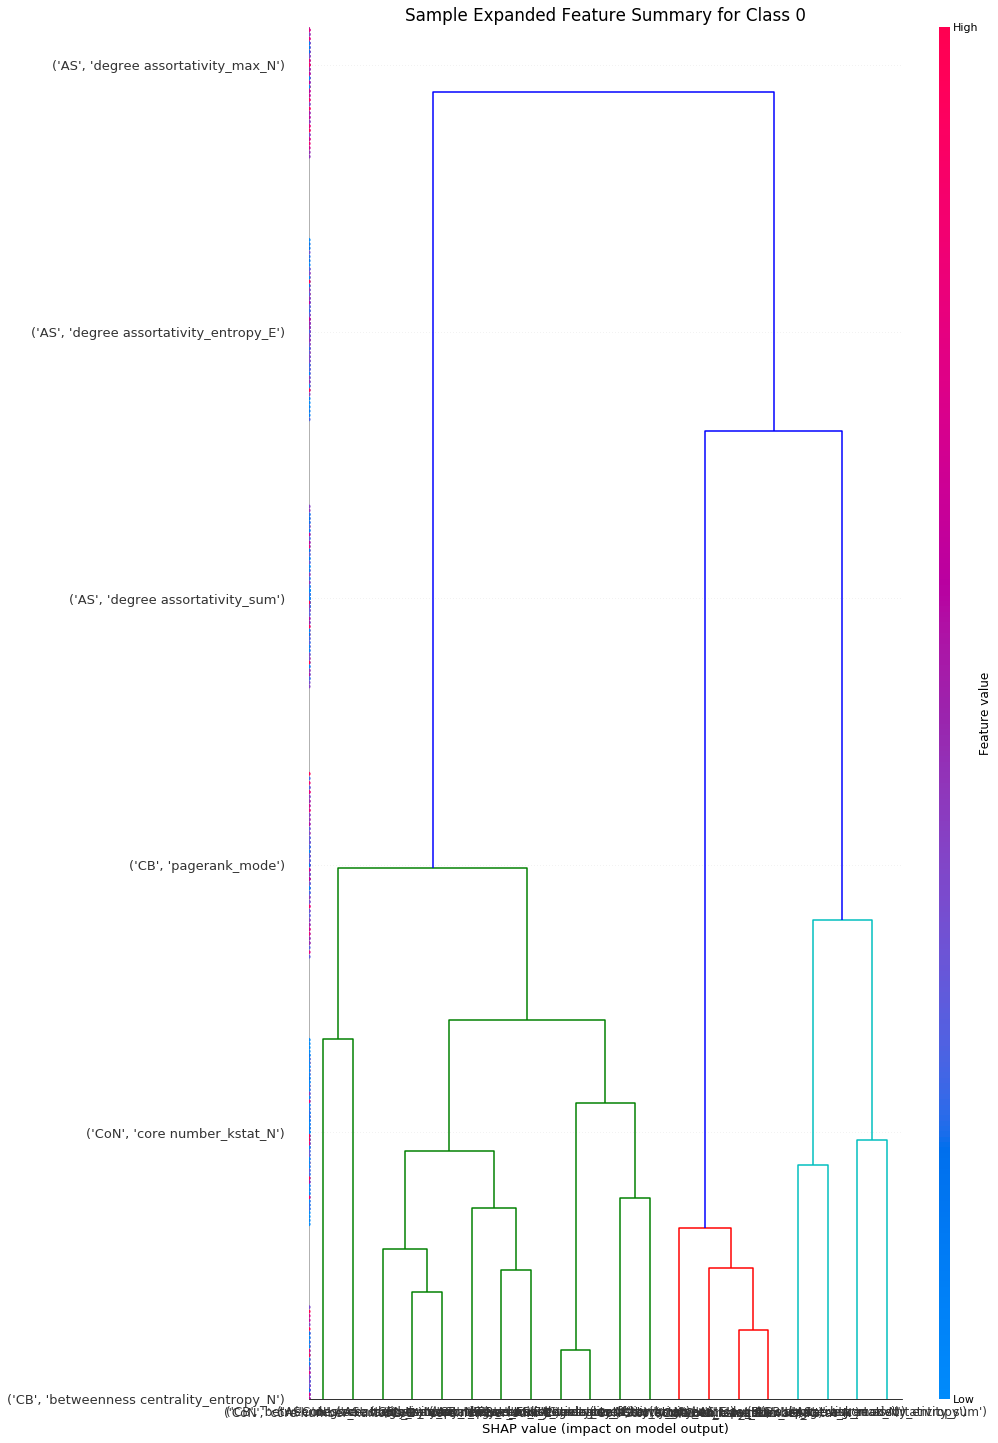

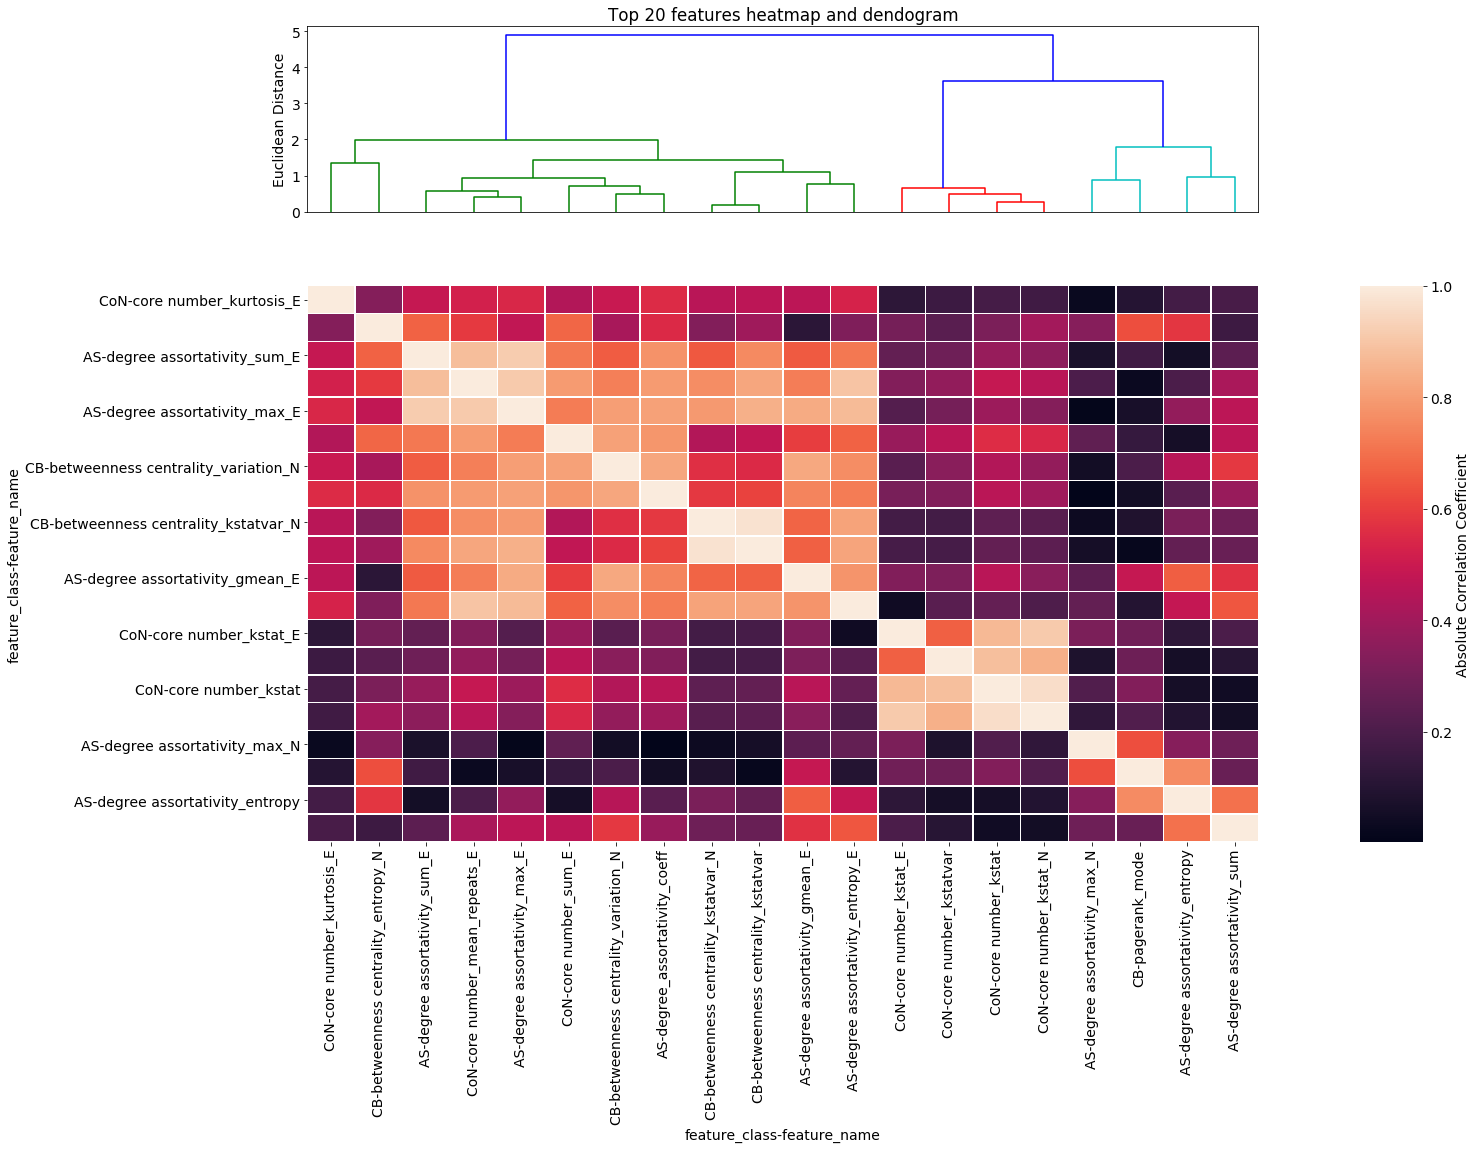

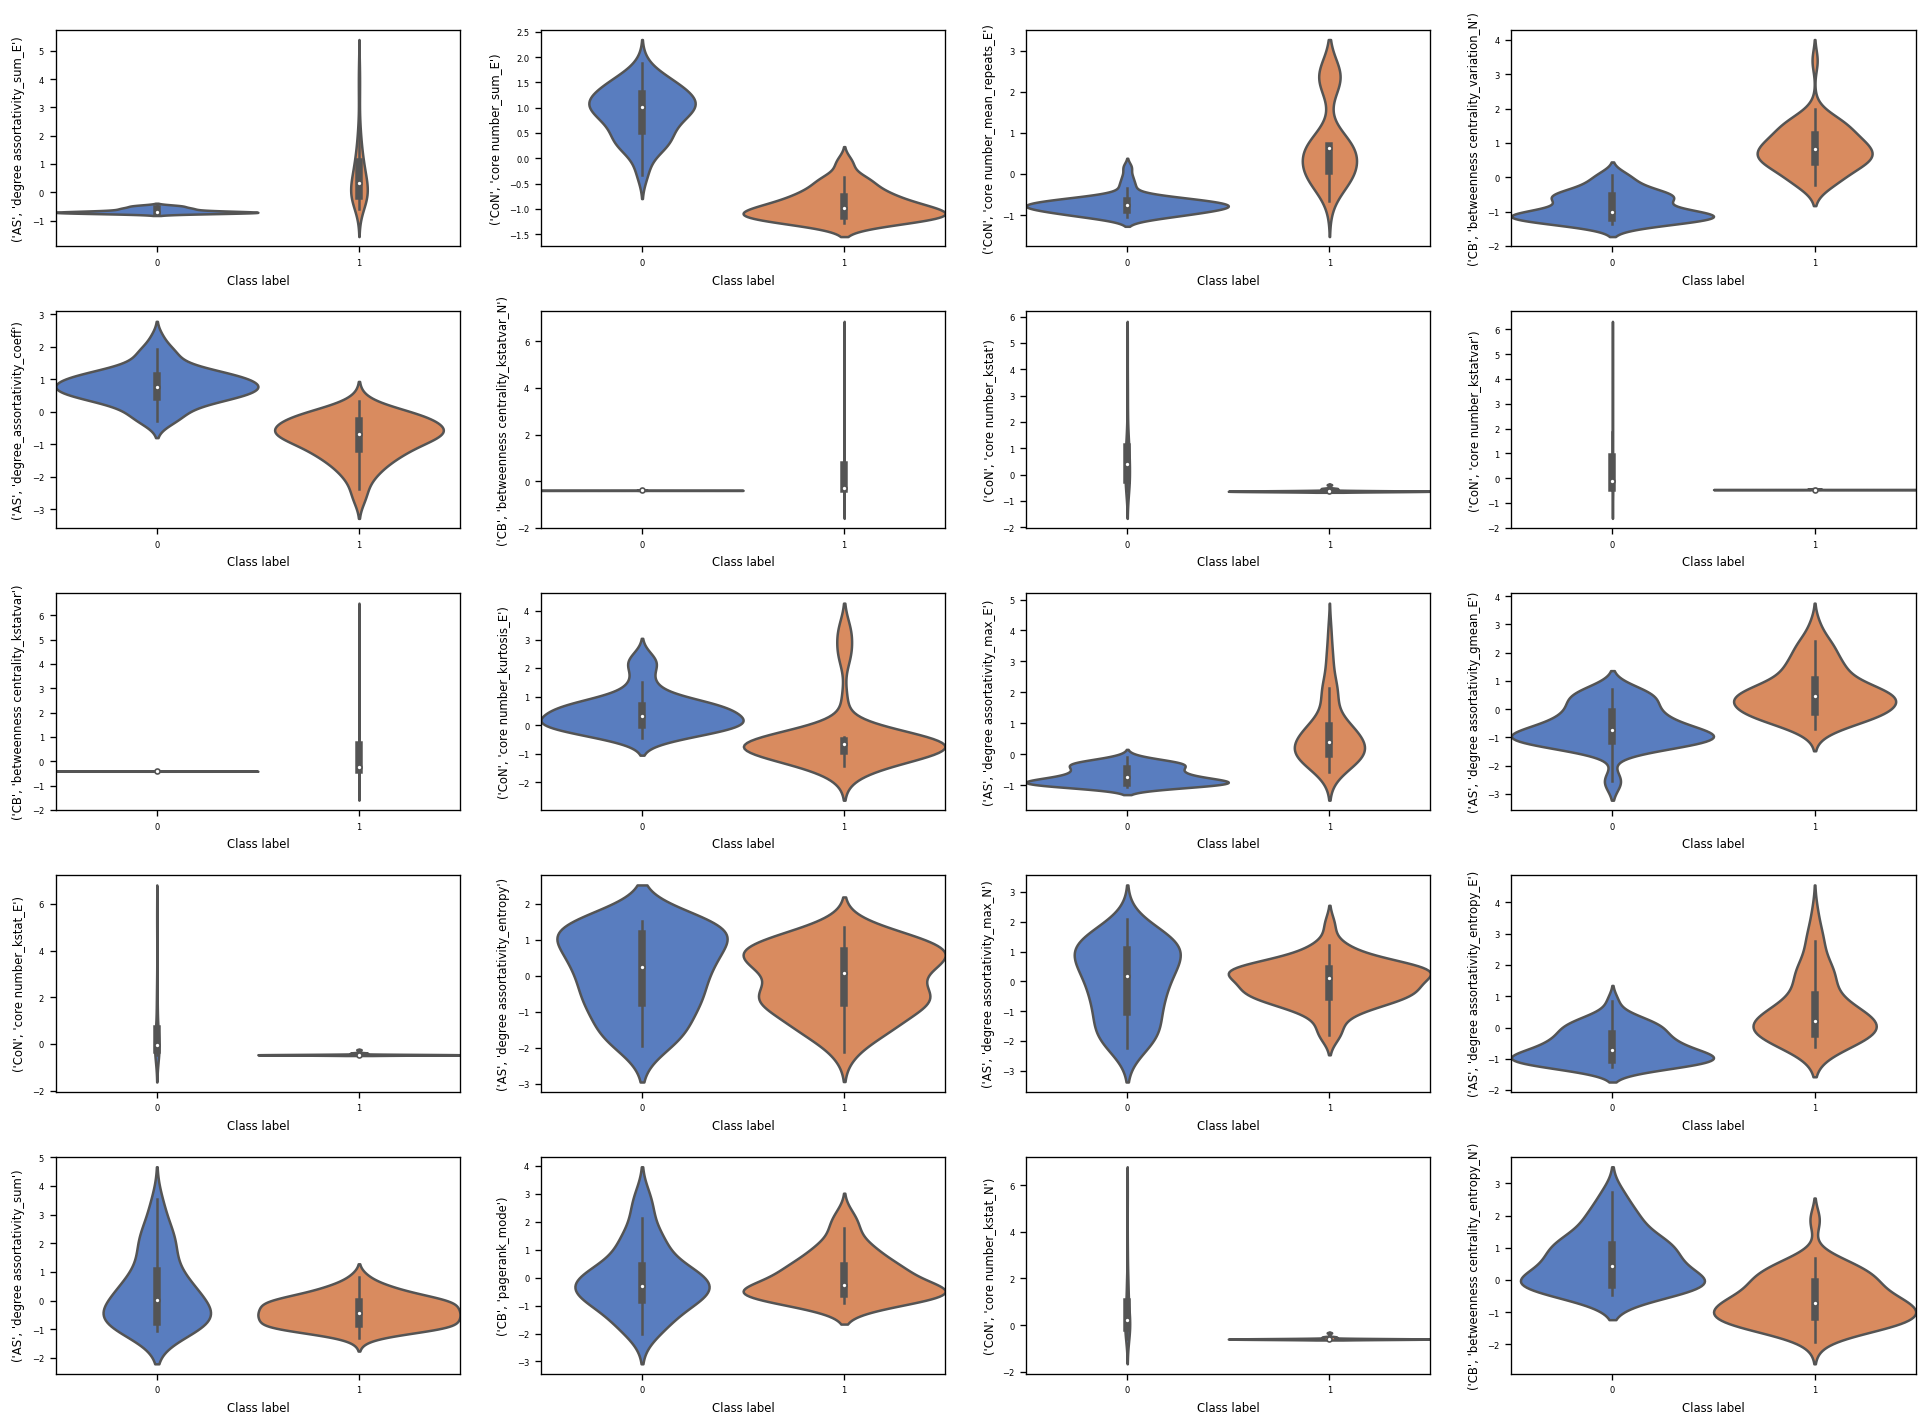

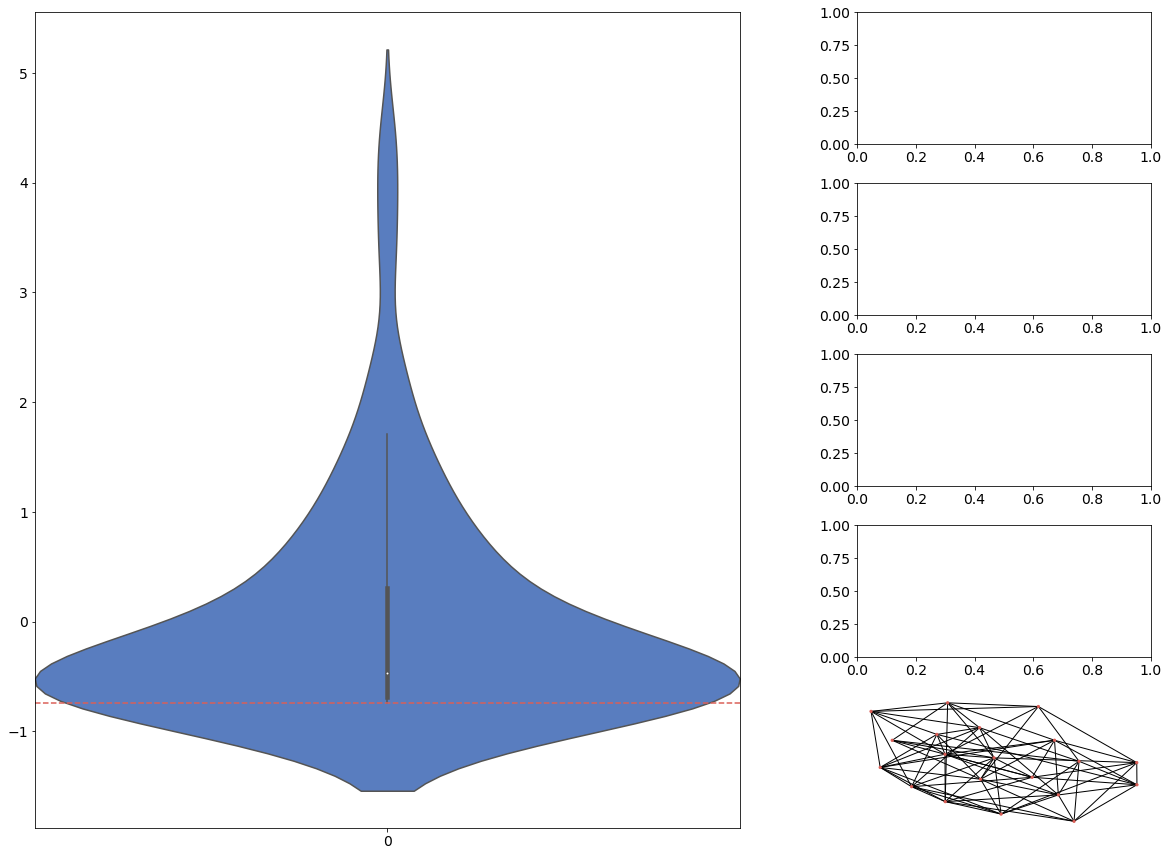

In [5]:
# implement a classification analyse of the features
h.analyse_features(feature_file='./results/custom_dataset/all_features.pkl',results_folder='./results/custom_dataset')
